In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.collocations import *
from nltk import word_tokenize
from nltk.corpus import stopwords 
import string
from nltk.tokenize import RegexpTokenizer
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, recall_score, precision_score, average_precision_score, accuracy_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels








In [20]:
reviews = pd.read_csv("Complete_reviews.csv")

/hpc/applications/anaconda/3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (15,200,201) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
def analyze_business(popular_id, data, min_ngram = 2, max_ngram = 2, 
                     min_doc_freq = .001, max_doc_freq = 0.7, pos_or_neg = 'pos'):
    data_sample = data[data['business_id'] == popular_id]
    data_text = data_sample['text'].copy()

    data_stars = data_sample['stars'].copy()
    data_stars = data_stars - 1

    clean_data = data_sample.drop(['Unnamed: 0', 'Unnamed: 0.1', 'business_id', "date", 'text',
                      'review_id', 'stars', 'user_id', 'name', 'Unnamed: 0_y',
                      'postal_code', "BestNights_business_id", "Music", 'latitude',
                      'longitude'],
                axis = 1)

    clean_data.rename({'stars.1': 'avg_stars'}, inplace =True)
    cols = clean_data.columns
    clean_data = np.nan_to_num(clean_data)
    clean_data = pd.DataFrame(clean_data)

    data_sparse = sparse.csr_matrix(clean_data.astype(float))

    vectorizer = TfidfVectorizer(stop_words = "english",
                                max_df = max_doc_freq,
                                min_df = min_doc_freq,
                                token_pattern = '[A-Za-z][A-Za-z]+',
                                ngram_range = (min_ngram, max_ngram))

    tfidf = vectorizer.fit_transform(data_text)
    full_sparse_matrix = sparse.hstack([data_sparse, tfidf])

    text_features = vectorizer.get_feature_names()
    # text_features = [w + '_' for w in text_features]
    nontext_features = cols

    features = np.concatenate((np.array(nontext_features, dtype = np.object), text_features), axis = None)
    features = features.tolist()
    # np.savetxt('scratch/tfidf_features_names_digrams_lr_' + popular_id + '.txt', features, delimiter = ',', fmt = '%s' )
    print(popular_id)
    print("Length of Vocabulary: " + str(len(vectorizer.get_feature_names())))
    X_train, X_test, y_train, y_test = train_test_split(full_sparse_matrix, data_stars, 
                                                        test_size = 0.4, random_state = 70)

    LR_clf = LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
                                intercept_scaling=1, max_iter=10000, multi_class='multinomial',
                                n_jobs=None, penalty='l2', random_state=50, solver='newton-cg',
                                tol=0.005, verbose=0, warm_start=False)
    LR_clf.fit(X_train, y_train)
    LR_preds = LR_clf.predict(X_test) + 1
    y_test += 1

    print("Logistic Regression Performance: ")
    print( "Accuracy: "+ str(accuracy_score(LR_preds, y_test)))
    plot_confusion_matrix(y_test, LR_preds, title = popular_id)
    feat = features
    coef = LR_clf.coef_
#     dic = dict(zip(feat, coef[0]))
#     sorted_by_value = sorted(dic.items(), key=lambda kv: kv[1], reverse = 1)
#     imp_feats = sorted_by_value[:20]
#     np.savetxt('tfidf_features_names_bigrams_lr_neg_' + popular_id + '.txt', 
#                imp_feats, delimiter = '\n', fmt = '%s' )
    
#     dic = dict(zip(feat, coef[4]))
#     sorted_by_value = sorted(dic.items(), key=lambda kv: kv[1], reverse = 1)
#     imp_feats = sorted_by_value[:20]
#     np.savetxt('tfidf_features_names_bigrams_lr_pos_' + popular_id + '.txt', 
#                imp_feats, delimiter = '\n', fmt = '%s' )
    
    diff_coef = coef[4] - coef[0]
    diff_dic = dict(zip(feat, diff_coef))
    diff_dic_sorted = sorted(diff_dic.items(), key=lambda kv:kv[1], reverse= (pos_or_neg == 'pos'))
    important_features=diff_dic_sorted[:20]
    np.savetxt('tfidf_features_names_'+ str(max_ngram) + 'grams_lr_total_'+ pos_or_neg +'_' + popular_id + '.txt', 
               important_features, delimiter = '\n', fmt = '%s' )
    


In [22]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [5]:
most_popular = ['4JNXUYY8wbaaDmk3BPzlWw', 'RESDUcs7fIiihp38-d6_6g',
       'K7lWdNUhCbcnEvI0NhGewg', 'cYwJA2A6I12KNkm2rtXd5g',
       'f4x1YBxkLrZg652xt2KR5g', 'DkYS3arLOhA8si5uUEmHOw',
       '2weQS-RnoOBhb1KsHKyoSQ', 'ujHiaprwCQ5ewziu0Vi9rw',
       'iCQpiavjjPzJ5_3gPD5Ebg', 'KskYqH1Bi7Z_61pH6Om8pg']

### Finding LR feature importance

#### Bigrams Positive

4JNXUYY8wbaaDmk3BPzlWw
Length of Vocabulary: 5411
Logistic Regression Performance: 
Accuracy: 0.53513174404
Confusion matrix, without normalization
[[  35   20   14   29   12]
 [  29   21   34   68   22]
 [  12   21   62  191   99]
 [   5    6   24  505  538]
 [   1    5   10  342 1083]]


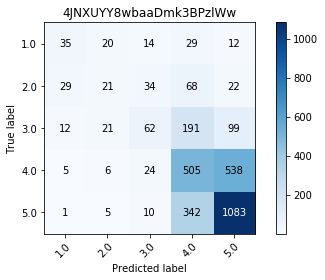

In [14]:
for restaurant in most_popular[:1]:
    analyze_business(restaurant, reviews, max_ngram = 2, min_ngram = 2, pos_or_neg='pos')

#### Trigrams Positive

In [14]:
for restaurant in most_popular:
    analyze_business(restaurant, reviews)

4JNXUYY8wbaaDmk3BPzlWw
Length of Vocabulary: 1003
Logistic Regression Performance: 
Accuracy: 0.508155583438
RESDUcs7fIiihp38-d6_6g
Length of Vocabulary: 1141
Logistic Regression Performance: 
Accuracy: 0.459459459459
K7lWdNUhCbcnEvI0NhGewg
Length of Vocabulary: 1071
Logistic Regression Performance: 
Accuracy: 0.413726250485
cYwJA2A6I12KNkm2rtXd5g
Length of Vocabulary: 1525
Logistic Regression Performance: 
Accuracy: 0.440840566469
f4x1YBxkLrZg652xt2KR5g
Length of Vocabulary: 1055
Logistic Regression Performance: 
Accuracy: 0.453785415699
DkYS3arLOhA8si5uUEmHOw
Length of Vocabulary: 1342
Logistic Regression Performance: 
Accuracy: 0.503763171099
2weQS-RnoOBhb1KsHKyoSQ
Length of Vocabulary: 950
Logistic Regression Performance: 
Accuracy: 0.399764150943
ujHiaprwCQ5ewziu0Vi9rw
Length of Vocabulary: 844
Logistic Regression Performance: 
Accuracy: 0.380806845966
iCQpiavjjPzJ5_3gPD5Ebg
Length of Vocabulary: 918
Logistic Regression Performance: 
Accuracy: 0.463848039216
KskYqH1Bi7Z_61pH6Om8pg

#### Bigrams Negative

In [18]:
for restaurant in most_popular:
    analyze_business(restaurant, reviews)

4JNXUYY8wbaaDmk3BPzlWw
Length of Vocabulary: 5411
Logistic Regression Performance: 
Accuracy: 0.53513174404
RESDUcs7fIiihp38-d6_6g
Length of Vocabulary: 7071
Logistic Regression Performance: 
Accuracy: 0.522098569157
K7lWdNUhCbcnEvI0NhGewg
Length of Vocabulary: 6307
Logistic Regression Performance: 
Accuracy: 0.473051570376
cYwJA2A6I12KNkm2rtXd5g
Length of Vocabulary: 6115
Logistic Regression Performance: 
Accuracy: 0.495660118776
f4x1YBxkLrZg652xt2KR5g
Length of Vocabulary: 4952
Logistic Regression Performance: 
Accuracy: 0.517417556897
DkYS3arLOhA8si5uUEmHOw
Length of Vocabulary: 5305
Logistic Regression Performance: 
Accuracy: 0.546412443552
2weQS-RnoOBhb1KsHKyoSQ
Length of Vocabulary: 5914
Logistic Regression Performance: 
Accuracy: 0.442806603774
ujHiaprwCQ5ewziu0Vi9rw
Length of Vocabulary: 5093
Logistic Regression Performance: 
Accuracy: 0.439486552567
iCQpiavjjPzJ5_3gPD5Ebg
Length of Vocabulary: 4337
Logistic Regression Performance: 
Accuracy: 0.531862745098
KskYqH1Bi7Z_61pH6Om8

#### Trigrams Negative

In [16]:
for restaurant in most_popular:
    analyze_business(restaurant, reviews)

4JNXUYY8wbaaDmk3BPzlWw
Length of Vocabulary: 1003
Logistic Regression Performance: 
Accuracy: 0.508155583438
RESDUcs7fIiihp38-d6_6g
Length of Vocabulary: 1141
Logistic Regression Performance: 
Accuracy: 0.459459459459
K7lWdNUhCbcnEvI0NhGewg
Length of Vocabulary: 1071
Logistic Regression Performance: 
Accuracy: 0.413726250485
cYwJA2A6I12KNkm2rtXd5g
Length of Vocabulary: 1525
Logistic Regression Performance: 
Accuracy: 0.440840566469
f4x1YBxkLrZg652xt2KR5g
Length of Vocabulary: 1055
Logistic Regression Performance: 
Accuracy: 0.453785415699
DkYS3arLOhA8si5uUEmHOw
Length of Vocabulary: 1342
Logistic Regression Performance: 
Accuracy: 0.503763171099
2weQS-RnoOBhb1KsHKyoSQ
Length of Vocabulary: 950
Logistic Regression Performance: 
Accuracy: 0.399764150943
ujHiaprwCQ5ewziu0Vi9rw
Length of Vocabulary: 844
Logistic Regression Performance: 
Accuracy: 0.380806845966
iCQpiavjjPzJ5_3gPD5Ebg
Length of Vocabulary: 918
Logistic Regression Performance: 
Accuracy: 0.463848039216
KskYqH1Bi7Z_61pH6Om8pg

In [17]:
def analyze_business2(popular_id, data):
    subset = np.logical_and(data['Chinese'] == 1, data['city_Las Vegas'] ==1)
    data_sample = data[subset]
    data_text = data_sample['text'].copy()

    data_stars = data_sample['stars'].copy()
    data_stars = data_stars - 1

    clean_data = data_sample.drop(['Unnamed: 0', 'Unnamed: 0.1', 'business_id', "date", 'text',
                      'review_id', 'stars', 'user_id', 'name', 'Unnamed: 0_y',
                      'postal_code', "BestNights_business_id", "Music", 'latitude',
                      'longitude'],
                axis = 1)

    clean_data.rename({'stars.1': 'avg_stars'}, inplace =True)
    cols = clean_data.columns
    clean_data = np.nan_to_num(clean_data)
    clean_data = pd.DataFrame(clean_data)

    data_sparse = sparse.csr_matrix(clean_data.astype(float))

    vectorizer = TfidfVectorizer(stop_words = "english",
                                max_df = 0.7,
                                min_df = .001,
                                token_pattern = '[A-Za-z][A-Za-z]+',
                                ngram_range = (2,2))

    tfidf = vectorizer.fit_transform(data_text)
    full_sparse_matrix = sparse.hstack([data_sparse, tfidf])

    text_features = vectorizer.get_feature_names()
    # text_features = [w + '_' for w in text_features]
    nontext_features = cols

    features = np.concatenate((np.array(nontext_features, dtype = np.object), text_features), axis = None)
    features = features.tolist()
    # np.savetxt('scratch/tfidf_features_names_digrams_lr_' + popular_id + '.txt', features, delimiter = ',', fmt = '%s' )
    print(popular_id)
    print("Length of Vocabulary: " + str(len(vectorizer.get_feature_names())))
    X_train, X_test, y_train, y_test = train_test_split(full_sparse_matrix, data_stars, 
                                                        test_size = 0.4, random_state = 70)

    LR_clf = LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
                                intercept_scaling=1, max_iter=10000, multi_class='multinomial',
                                n_jobs=None, penalty='l2', random_state=50, solver='newton-cg',
                                tol=0.005, verbose=0, warm_start=False)
    LR_clf.fit(X_train, y_train)
    LR_preds = LR_clf.predict(X_test)

    print("Logistic Regression Performance: ")
    print( "Accuracy: "+ str(accuracy_score(LR_preds, y_test)))
    
    feat = features
    coef = LR_clf.coef_
    
    diff_coef = coef[4] - coef[0]
    diff_dic = dict(zip(feat, diff_coef))
    diff_dic_sorted = sorted(diff_dic.items(), key=lambda kv:kv[1], reverse=1)
    important_features=diff_dic_sorted[:20]
    np.savetxt('tfidf_features_names_bigrams_lr_total_pos_' + popular_id + '.txt', 
               important_features, delimiter = '\n', fmt = '%s' )
    
    diff_coef = coef[4] - coef[0]
    diff_dic = dict(zip(feat, diff_coef))
    diff_dic_sorted = sorted(diff_dic.items(), key=lambda kv:kv[1], reverse=0)
    important_features=diff_dic_sorted[:20]
    np.savetxt('tfidf_features_names_bigrams_lr_total_neg_' + popular_id + '.txt', 
               important_features, delimiter = '\n', fmt = '%s' )
    


### All Data

In [ ]:
data_sample = reviews.sample(frac = 0.1, random_state = 4919)

data_text = data_sample['text'].copy()

stars = data_sample['stars'].copy()
stars = stars - 1
data_sample['compound'] = data_sample['compound'] + 1

data_sample.drop(['Unnamed: 0', 'Unnamed: 0.1', 'business_id', "date", 'text',
                  'review_id', 'stars', 'user_id', 'name', 'Unnamed: 0_y',
                  'postal_code', "BestNights_business_id", "Music", 'latitude',
                  'longitude'],
            axis = 1,
            inplace = True)

data_sample.rename({'stars.1': 'avg_stars'}, inplace =True)
data_sample = np.nan_to_num(data_sample)

data_sparse = sparse.csr_matrix(data_sample.astype(float))

vectorizer = TfidfVectorizer(stop_words = "english",
                            max_df = 0.7,
                            min_df = .001,
                            ngram_range = (1,1),
                            token_pattern = '[A-Za-z][A-Za-z]+')

tfidf = vectorizer.fit_transform(data_text)
full_sparse_matrix = sparse.hstack([data_sparse, tfidf])

print("Length of Vocabulary: " + str(len(vectorizer.get_feature_names())))

X_train, X_test, y_train, y_test = train_test_split(full_sparse_matrix, stars, test_size = 0.4, random_state = 70)
LR_clf = LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
                            intercept_scaling=1, max_iter=10000, multi_class='multinomial',
                            n_jobs=None, penalty='l2', random_state=50, solver='newton-cg',
                            tol=0.005, verbose=0, warm_start=False)
LR_clf.fit(X_train, y_train)
LR_preds = LR_clf.predict(X_test)
plot_confusion_matrix(y_test, LR_preds, title = "All Data")
print("Logistic Regression Performance: ")
print( "Accuracy: "+ str(accuracy_score(LR_preds, y_test)))